In [50]:
# Load Dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

Categorical columns: Index(['x14', 'x15'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   x1              1030 non-null   float64
 1   x2              1030 non-null   float64
 2   x3              1030 non-null   float64
 3   x4              1030 non-null   float64
 4   x5              1030 non-null   float64
 5   x6              1030 non-null   float64
 6   x7              1030 non-null   float64
 7   x8              1030 non-null   int64  
 8   x9              1030 non-null   float64
 9   x10             1030 non-null   float64
 10  x11             1030 non-null   float64
 11  x12             1030 non-null   int64  
 12  x13             1030 non-null   float64
 13  target_feature  1030 non-null   float64
 14  x14_Y E S       1030 non-null   bool   
 15  x14_YES         1030 non-null   bool   
 16  x14_YEs         103

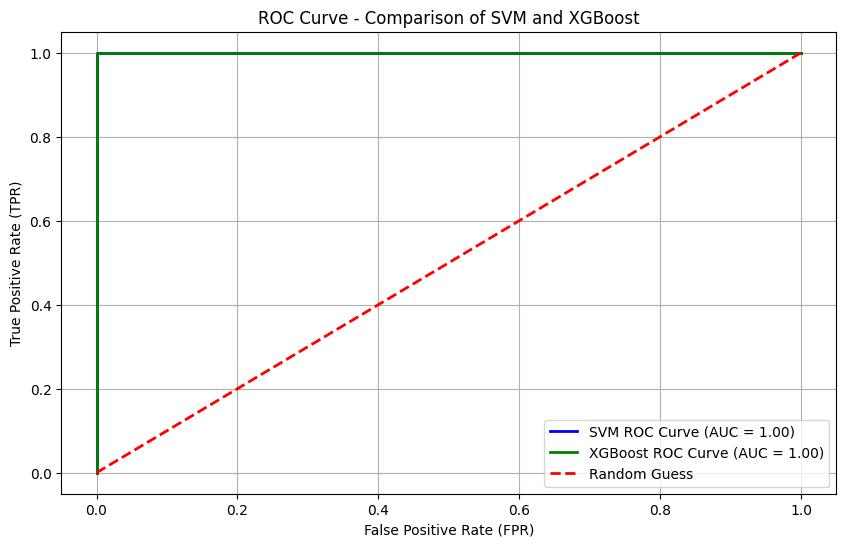

SVM Accuracy: 1.0000
XGBoost Accuracy: 1.0000


In [64]:
# 2. Data Preprocessing
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

# One-hot encoding of categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_columns)
print("Dataset after encoding:", df_encoded.info())

# Assuming the last column is the target
X = df_encoded.iloc[:, :-1]  # Features (all columns except the target)
y = df_encoded.iloc[:, -1]   # Target (last column)

# Encode target if necessary
if y.dtype == 'object':
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize data using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3. Hyperparameter Tuning with GridSearchCV
# 3.1 SVM Classifier
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'] + [0.01, 0.1, 1, 10],
    'kernel': ['rbf']
}

svm_grid_search = GridSearchCV(SVC(class_weight='balanced', probability=True), svm_param_grid, cv=5, scoring='accuracy')
svm_grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV for SVM
print("Best SVM parameters:", svm_grid_search.best_params_)

# Train the SVM model with the best parameters
svm_classifier = svm_grid_search.best_estimator_
svm_classifier.fit(X_train, y_train)

# 3.2 XGBoost Classifier
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}

xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_param_grid, cv=5, scoring='accuracy')
xgb_grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV for XGBoost
print("Best XGBoost parameters:", xgb_grid_search.best_params_)

# Train the XGBoost model with the best parameters
xgb_classifier = xgb_grid_search.best_estimator_
xgb_classifier.fit(X_train, y_train)

# 4. Predictions
svm_y_pred = svm_classifier.predict(X_test)
svm_y_pred_prob = svm_classifier.predict_proba(X_test)[:, 1]

xgb_y_pred = xgb_classifier.predict(X_test)
xgb_y_pred_prob = xgb_classifier.predict_proba(X_test)[:, 1]

# 5. Model Evaluation
# 5.1 Classification Report
print("SVM Classification Report:\n", classification_report(y_test, svm_y_pred))
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_y_pred))

# 5.2 Confusion Matrix
svm_conf_matrix = confusion_matrix(y_test, svm_y_pred)
xgb_conf_matrix = confusion_matrix(y_test, xgb_y_pred)
print("SVM Confusion Matrix:\n", svm_conf_matrix)
print("XGBoost Confusion Matrix:\n", xgb_conf_matrix)

# 5.3 ROC Curve Evaluation
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, svm_y_pred_prob)
svm_roc_auc = auc(svm_fpr, svm_tpr)

xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_y_pred_prob)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(svm_fpr, svm_tpr, color='blue', lw=2, label=f'SVM ROC Curve (AUC = {svm_roc_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, color='green', lw=2, label=f'XGBoost ROC Curve (AUC = {xgb_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Guess')
plt.title('ROC Curve - Comparison of SVM and XGBoost')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# 6. Evaluate Accuracy
svm_accuracy = accuracy_score(y_test, svm_y_pred)
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")